In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

##1. Custom dataset class 구현


해당 과제에서는 허깅페이스의 StockLlama/ETH-USD-2022-01-01_2024-08-30 데이터셋을 사용하였습니다.

해당 데이터셋은 Llama모델을 주가 예측 task를 사용하기 위해 사용되고, 제목에 적혀있는 날짜 만큼의 데이터셋을 가지고 있습니다.

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.9 MB/s eta 0:00:00


In [3]:
import pandas as pd

from datasets import load_dataset

dataset = load_dataset("StockLlama/ETH-USD-2022-01-01_2024-08-30")

df = dataset["train"].to_pandas()

df

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/313 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/39.8k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/716 [00:00<?, ? examples/s]

,input_ids,label
0,"[91.308495, 93.06198, 91.06491, 92.02197, 84.8...",28.777820
1,"[93.06198, 91.06491, 92.02197, 84.885086, 81.0...",24.001883
2,"[91.06491, 92.02197, 84.885086, 81.01954, 74.4...",22.852409
3,"[92.02197, 84.885086, 81.01954, 74.42368, 71.4...",23.944717
4,"[84.885086, 81.01954, 74.42368, 71.45851, 73.3...",20.007884
...,...,...
711,"[47.109726, 48.74788, 45.899754, 46.122032, 45...",61.417749
712,"[48.74788, 45.899754, 46.122032, 45.230312, 45...",59.431441
713,"[45.899754, 46.122032, 45.230312, 45.839302, 4...",52.911262
714,"[46.122032, 45.230312, 45.839302, 44.68528, 45...",54.952393


In [4]:
import numpy as np

# input_ids를 NumPy 배열로 변환
input_array = np.array(df["input_ids"].tolist(), dtype=np.float32)
label_array = np.array(df["label"].tolist(), dtype=np.float32)

# shape 출력
print("input_ids shape:", input_array.shape)
print("label shape:", label_array.shape)

input_ids shape: (716, 256)
label shape: (716,)


총 716개의 데이터셋으로 이루어져 있는 것을 확인할 수 있고, 각 데이터셋마다 256개의 feature로 이루어져있었습니다.  

그리고 데이터셋의 각 256의 마지막 부분을 예측하는 문제임을 알 수 있었습니다.

In [12]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

def preprocess_data(df):
    data = np.array(df["input_ids"].tolist(), dtype=np.float32)
    labels = np.array(df["label"].tolist(), dtype=np.float32).reshape(-1, 1)

    train_size = int(len(data) * 0.8)
    train_data, test_data = data[:train_size], data[train_size:]
    train_labels, test_labels = labels[:train_size], labels[train_size:]

    train_data = np.expand_dims(train_data, axis=-1)
    test_data = np.expand_dims(test_data, axis=-1)

    return train_data, train_labels, test_data, test_labels

class StockDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# 데이터 전처리
train_seq, train_labels, test_seq, test_labels = preprocess_data(df)

# 데이터셋 및 DataLoader 생성
train_dataset = StockDataset(train_seq, train_labels)
test_dataset = StockDataset(test_seq, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 데이터 형태 확인
print("Train Data Shape:", train_seq.shape)
print("Train Labels Shape:", train_labels.shape)
print("Test Data Shape:", test_seq.shape)
print("Test Labels Shape:", test_labels.shape)


Train Data Shape: (572, 256, 1)
Train Labels Shape: (572, 1)
Test Data Shape: (144, 256, 1)
Test Labels Shape: (144, 1)


In [13]:
for sample_X, sample_y in train_loader:
    print("입력 데이터 (X) shape:", sample_X.shape)
    print("라벨 (y) shape:", sample_y.shape)
    break

입력 데이터 (X) shape: torch.Size([32, 256, 1])
라벨 (y) shape: torch.Size([32, 1])


RNN의 인풋으로 들어가는 데이터의 차원은 (batch_size, sequence_length, feature_dim)입니다.

여기에서 feature은 1차원이므로 저희의 데이터는 (batch_size, sequence_length, 1)의 형태로 나타나게 됩니다.

##2. 모델 Class

모델은 RNN, LSTM, GRU 총 3개로 구현되어있고, LSTM은 게이트를 여러개 추가하여 기울기소실 문제를 완화시켜 RNN의 long term dependency를 해결하게 된 모델입니다. GRU모델은 LSTM과 유사하지만, 더 간단한 구조를 가져 빠른 학습이 가능한 모델입니다.

세 모델 모두 마지막에 self.fc(out)을 통하여 가장 마지막 타임스텝에서 나온 출력을 바탕으로 최종 예측값을 얻게 하였습니다.

또한 정규화 방식으로 layer normalize를 사용하여 RNN을 거쳐서 나온 후 step별로 hidden state를 normalize하게 되었습니다.

In [17]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.layer_norm(out[:, -1, :])
        out = self.activation(out)
        return self.fc(out)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.layer_norm(out[:, -1, :])
        out = self.activation(out)
        return self.fc(out)

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.layer_norm(out[:, -1, :])
        out = self.activation(out)
        return self.fc(out)


##3. 모델 Train

In [22]:
import time

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50):
    model.train()
    losses = []
    validation_losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        correct = 0
        total = 0

        for seqs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(seqs)

            loss = criterion(outputs, labels.view(-1, 1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)

        losses.append(avg_loss)

        # validation set으로 test_loader 사용
        model.eval()
        val_loss = test_model(model, test_loader, criterion)
        validation_losses.append(val_loss)

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.6f}, Validation Loss: {val_loss:.6f}")

        model.train()

    return losses, validation_losses

def test_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for seqs, labels in test_loader:
            outputs = model(seqs)
            loss = criterion(outputs, labels.view(-1, 1))
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    return avg_loss

models = {
    "RNN": RNNModel(input_size=1, hidden_size=64, output_size=1),
    "LSTM": LSTMModel(input_size=1, hidden_size=64, output_size=1),
    "GRU": GRUModel(input_size=1, hidden_size=64, output_size=1)
}

criterion = nn.MSELoss()
num_epochs = 300
training_results = {}
validation_results = {}
test_loss_list = []
training_time_list = []

for name, model in models.items():
    print(f"Training {name}...")
    start_time = time.time()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    losses, val_losses= train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)
    training_results[name] = {"losses": losses}
    validation_results[name] = {"losses": val_losses}

    test_loss = test_model(model, test_loader, criterion)
    test_loss_list.append(test_loss)
    print(f"{name} Test Loss: {test_loss:.6f}")

    end_time = time.time()
    training_time = end_time - start_time
    training_time_list.append(training_time)

print("RNN Test Loss : ", test_loss_list[0])
print("LSTM Test Loss : ", test_loss_list[1])
print("GRU Test Loss : ", test_loss_list[2])

print("RNN Training Time: ", training_time_list[0], "seconds")
print("LSTM Training Time: ", training_time_list[1], "seconds")
print("GRU Training Time: ", training_time_list[2], "seconds")

Training RNN...
Epoch 10/300, Train Loss: 1473.136010, Validation Loss: 5199.144629
Epoch 20/300, Train Loss: 1358.139048, Validation Loss: 4935.273535
Epoch 30/300, Train Loss: 1296.064626, Validation Loss: 4758.652979
Epoch 40/300, Train Loss: 1237.626685, Validation Loss: 4639.090479
Epoch 50/300, Train Loss: 1188.269392, Validation Loss: 4522.547559
Epoch 60/300, Train Loss: 1134.245690, Validation Loss: 4406.344971
Epoch 70/300, Train Loss: 1083.076989, Validation Loss: 4288.410742
Epoch 80/300, Train Loss: 1029.657681, Validation Loss: 4168.120996
Epoch 90/300, Train Loss: 979.011834, Validation Loss: 4046.108350
Epoch 100/300, Train Loss: 928.401154, Validation Loss: 3922.936719
Epoch 110/300, Train Loss: 881.212440, Validation Loss: 3798.538867
Epoch 120/300, Train Loss: 829.366194, Validation Loss: 3673.697827
Epoch 130/300, Train Loss: 784.379266, Validation Loss: 3548.831616
Epoch 140/300, Train Loss: 737.075957, Validation Loss: 3424.402563
Epoch 150/300, Train Loss: 693.06

- 우선 RNN > GRU > LSTM 순으로 Loss가 클 것으로 예상하게 되었습니다.

- 예상대로 TEST Loss가 가장 낮은 모델은 LSTM인것을 확인할 수 있었습니다.

- 하지만 GRU모델의 Loss가 RNN의 Loss보다 높게 나와 예상과는 달랐지만, LSTM보다는 Loss가 높은 것을 보았을 때 LSTM의 cell state와 다양한 gate가 장기 기억에 좀 더 효과가 좋음을 알 수 있었습니다.

##4. 시각화

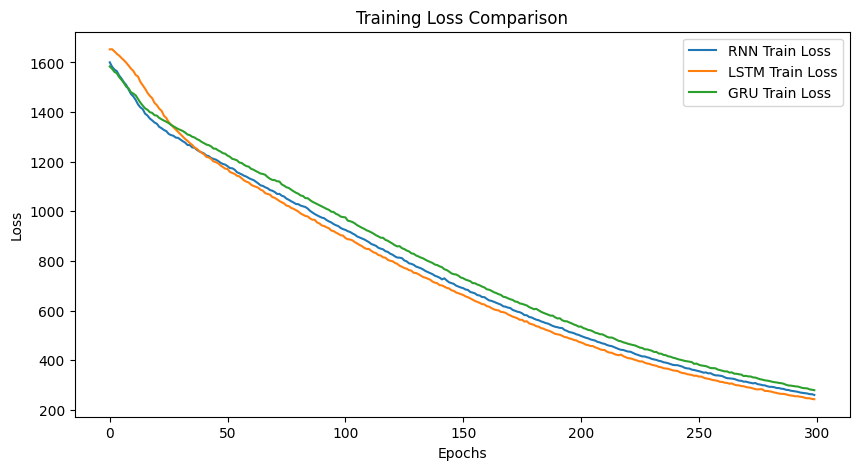

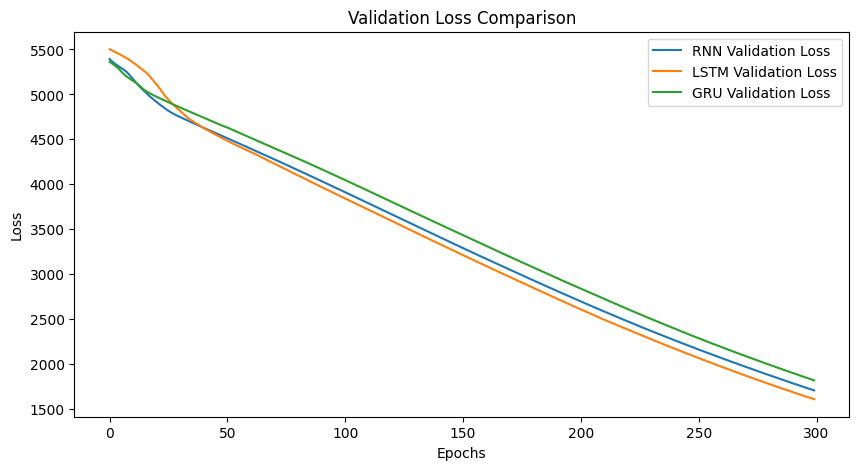

In [23]:
import matplotlib.pyplot as plt

# 학습 경향성 시각화 (Train Loss)
plt.figure(figsize=(10, 5))
for name, result in training_results.items():
    plt.plot(result['losses'], label=f"{name} Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss Comparison")
plt.show()

# 학습 경향성 시각화 (Validation Loss)
plt.figure(figsize=(10, 5))
for name, result in validation_results.items():
    plt.plot(result['losses'], label=f"{name} Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Validation Loss Comparison")
plt.show()



RNN, LSTM, GRU에 대한 학습그래프입니다.

세 모델 모두 Loss가 잘 떨어짐을 볼 수 있었습니다.

## 결과 분석 및 고찰

RNN의 long term dependency 문제는 LSTM의 모델 구조 변화를 통해 완화된 것을 확인할 수 있었습니다.

그러나 데이터셋의 특성 때문인지, RNN보다 성능이 더 높아야 할 GRU가 오히려 가장 낮은 성능을 기록하는 결과를 볼 수 있었습니다.

이 과제를 통해 시계열 데이터셋을 어떻게 효과적으로 학습시킬 수 있는지 배울 수 있었습니다.

하지만 결국 모든 모델들이 long term dependency 문제의 근본적인 해결에는 한계가 있음을 알게 되었고, 이를 해결하기 위해 transformer 모델을 적용하면 기울기 소실 문제를 해결하고 더 나은 성능을 얻을 수 있을 것이라 기대하고 있습니다.